In [2]:
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.signal import find_peaks

# suppress empty legend warnings
import logging
logging.getLogger().setLevel(logging.CRITICAL)

# for error propagation
import uncertainties as unc
import uncertainties.unumpy as unp

In [3]:
plt.rcParams['font.size'] = 15  # Base font size
# plt.rcParams['axes.titlesize'] = 14  # Title font size
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 16  # Legend font size

In [33]:
class RFAData:
    def __init__(self, filename):
        """Initialize RFA data from a measurement file."""
        # Header information
        self.measurement_date = None
        self.operator = ""
        self.comments = ""
        self.projectile = ""
        
        # Beam parameters
        self.energy = 0.0
        self.extractor = 0.0
        self.focus1 = 0.0
        self.focus2 = 0.0
        
        # RFA parameters
        self.suppressor_voltage = 0.0
        self.rfa_comments = ""
        self.ret_config = ""
        self.supp_config = ""
        
        # Wien filter
        self.wien_voltage = 0.0
        
        # Sweep parameters
        self.sweep_start = 0.0
        self.is_peak = False
        self.sweep_end = 0.0
        self.sweep_step = 0.0
        self.measurement_time = 0.0
        self.integration_time = 0.0
        self.plc = 0.0
        self.points_per_step = 0.0
        
        # Measurement data
        self.retarding_voltage = None  # Will be numpy array
        self.current = None       # Will be numpy array
        self.current_0 = None     # Will be numpy array
        self.current_norm = None  # Will be numpy array

        self._is_normalized = False

        
        self._load_file(filename)
        self._read_configuration()
        self._remove_first_point()
        self._normalize_current()
    
    def _load_file(self, filename):
        """Load and parse the measurement file."""
        # print(f"loading file: {filename}")
        with open(filename, 'r') as file:
            lines = file.readlines()
            
        # Parse header information
        data_start_index = None
        in_rfa_section = False  # Flag to track if we're in the RFA section


        # first, record date (that doesn't fit the standard ":" format):
        datetime_str = lines[0].strip().replace("Measured on ", "")
        self.measurement_date = datetime.strptime(datetime_str, "%H:%M:%S %d/%m/%Y")
        
        for i, line in enumerate(lines):
            line = line.strip()
            
            if not line:
                continue
            
            # Check for data section
            if "Retading voltage (kV)" in line and "Mean current FC (A)" in line:
                data_start_index = i + 1
                break
                
            # Check if we're entering RFA section
            if "RFA#:" in line:
                in_rfa_section = True
                
            # Handle fields that might be empty
            if ":" in line:
                parts = line.split(':', 1)  # Split on first colon only
                field = parts[0].strip()
                value = parts[1].strip() if len(parts) > 1 else ""
                
                # Remove any remaining tabs
                value = value.replace('\t', '').strip()
                    
                if field == "Operated by":
                    self.operator = value
                elif field == "Comments":
                    # Assign to appropriate comments field based on section
                    if in_rfa_section:
                        self.rfa_comments = value
                    else:
                        self.comments = value
                elif field == "Projectile":
                    self.projectile = value
                elif field == "Energy (V)":
                    self.energy = float(value)/1000 if value else 0.0 # also convert to kV
                elif field == "Extractor (%)":
                    self.extractor = float(value) if value else 0.0
                elif field == "Focus 1 (%)":
                    self.focus1 = float(value) if value else 0.0
                elif field == "Focus 2 (%)":
                    self.focus2 = float(value) if value else 0.0
                elif field == "Suppressor voltage (V)":
                    self.suppressor_voltage = float(value) if value else 0.0
                elif field == "Wien voltage (V)":
                    self.wien_voltage = float(value) if value else 0.0
                elif field == "Sweep start (kV)":
                    self.sweep_start = float(value) if value else 0.0
                    # set if peak or whole
                    if self.sweep_start <= 0.1:
                        self.is_peak = False
                    else:
                        self.is_peak = True
                elif field == "Sweep end (kV)":
                    self.sweep_end = float(value) if value else 0.0
                elif field == "Sweep step (V)":
                    self.sweep_step = float(value)/1000 if value else 0.0 # also convert to kV
                elif field == "Measurement time (s)":
                    self.measurement_time = float(value) if value else 0.0
                elif field == "Integration time (s)":
                    self.integration_time = float(value) if value else 0.0
                elif field == "PLC":
                    self.plc = float(value) if value else 0.0
                elif field == "Points per step":
                    self.points_per_step = float(value) if value else 0.0
        
        if data_start_index is None:
            raise ValueError("Could not find data section in file")
            
        # Parse measurement data
        data_lines = [line.strip() for line in lines[data_start_index:] if line.strip()]
        voltage_data = []
        current_data = []
        
        for line in data_lines:
            v, i = line.split('\t')
            voltage_data.append(float(v.replace('E', 'e')))
            current_data.append(float(i.replace('E', 'e')))
        
        self.retarding_voltage = np.array(voltage_data)
        self.current = np.array(current_data)

    def _read_configuration(self):
            """Set RFA configuration based on measurement date"""
            date_configs = {
                "2024-11-27": (1, "2grid", "1grid"),
                "2024-11-29": (2, "2grid", "d=4.8mm"),
                "2024-12-04": (3, "1grid", "1grid"),
                "2024-12-06": (4, "1grid", "d=9.5mm")
            }
            
            date_str = self.measurement_date.strftime(r"%Y-%m-%d")
            if date_str in date_configs:
                self.measurement_day, self.ret_config, self.supp_config = date_configs[date_str]

    def _remove_first_point(self):
        """Remove first point from measurement data arrays, as that is most often erroneous."""
        if len(self.retarding_voltage) > 0 and len(self.current) > 0:
            self.retarding_voltage = self.retarding_voltage[1:]
            self.current = self.current[1:]
    
    def _normalize_current(self):
        """Create two copies of the original current data,
           the original and the one normalized to the first point."""
        self.current_0 = np.copy(self.current)
        if not self.is_peak: # peaks can't be normalized
            # TODO: shift all the peaks to end at 0
            self.current_norm = np.copy(self.current_0) / self.current_0[0]

    def __repr__(self):
        return (f"RFAData: \n"
                f"\tretarding configuration = {self.ret_config}, \n"
                f"\tsuppressor configuration = {self.supp_config}, \n"
                f"\tbeam energy = {self.energy} kV, \n"
                f"\tsweep starting voltage = {self.sweep_start} kV, \n"
                f"\tsuppressor voltage = {self.suppressor_voltage}")
    
    # normalized setting, so all code runs as before, the correct current data is update behind
    @property
    def is_normalized(self):
        return self._is_normalized

    @is_normalized.setter
    def is_normalized(self, norm_set):
        if self.is_peak: # can't normalize peaks
            print("Can't normalize peak data")
            self._is_normalized = False
        else:
            self._is_normalized = norm_set
            # set the current data
            if norm_set:
                self.current = self.current_norm
            else:
                self.current = self.current_0

    
    def get_data_for_fit(self, plot=False, max_current=None):
        """Prepare the data for fitting the Gaussian error function.
           Pads the data to only have the main drop-off, 
           with constant values on either side of it. 
           Max current: either the last peak or a custom value, used for left padding start.
            
            If plot true it also returns: fig, ax."""
        
        if max_current:
            # where it's the closest
            max_current_index = np.argmin(np.abs(self.current - max_current))
        else:
            x_peak, y_peak = find_last_peak_before_dropoff(self.retarding_voltage, self.current)
            # print(y_peak)
            max_current_index = np.where(self.current == y_peak)[0][-1]
        
        # Find the index of the last peak

        # Create a padding so that the values before the max current just take the value of the max current
        x_data = self.retarding_voltage
        y_data = np.copy(self.current)

        # front pad 
        y_data[:max_current_index] = y_data[max_current_index]
        
        # back pad
        # Add padding on the other side until 1.1 * self.energy, we original step size
        padding_ret = np.arange(x_data[-1], 1.1 * self.energy, self.sweep_step)
        padding_current = np.full_like(padding_ret, y_data[-1])

        x_data = np.concatenate((x_data, padding_ret))
        y_data = np.concatenate((y_data, padding_current))

        if plot:
            fig, ax = format_plot(show=False, rfa_datas=[self])
            ax.plot(x_data, y_data, 'g--', label='padded data')
            format_plot(figax=(fig, ax))
            return x_data, y_data, fig, ax

        return x_data, y_data, None, None

    def calc_fwhm(self, plot=False, max_current=None):
        """Calculate energy resolution as FWHM.
           Fit Gaussian error function to the RFA data and plot the result.
           Max current: either the last peak or a custom value, used for left padding start."""
        x_data, y_data, _, _ = self.get_data_for_fit(plot=False, max_current=max_current)   

        # Fit Gaussian error function
        popt_erf, pcov_erf = fit_gaussian_erf(x_data, y_data)
        # convert covariance matrix to unc
        popt_erf_unc = unc.correlated_values(popt_erf, pcov_erf)
        
        # Derivative of Gaussian error function is a Gaussian
        a, b, c, d = popt_erf_unc
        popt_gaussian = [a / (c * unp.sqrt(2 * np.pi)), b, c, 0]
        
        # Calculate FWHM (Full Width at Half Maximum)
        a, b, c, d = popt_gaussian
        fwhm = 2 * np.sqrt(2 * np.log(2)) * c
        fwhm_percent = fwhm / b * 100
        print(f"FWHM: {fwhm:.3f} kV, FWHM as % of center: {fwhm_percent:.2f}%")
        
        if plot:
            fig, ax = format_plot(show=False)
            if max_current:
                ax.axhline(y=max_current, color='b', linestyle='--', label='max current')
            ax.plot(x_data, y_data, 'g--', label='padded data')
            ax.plot(x_data, gaussian_erf(x_data, *popt_erf), 'r--',
                    label=f'erf fit --> FWHM: {fwhm_percent:.3f}%')
            format_plot(figax=(fig, ax), rfa_datas=[self])
        return fwhm_percent
    



def format_plot(nrows=None, figsize=(12, 5), figax=None, show=True, rfa_datas=None, is_norm=None):
    """
    ncol (int): Number of rows for the legend.
    figsize (tuple): (width, height)
    figax (tuple): If None, a new figure and axis are created.
    show (bool): If True, the plot is displayed. If False, the figure and axis are returned. Default is True.
    rfa_datas (list): A list of RFAData objects. Default is no data plotted.
    """
    if figax:
        fig, ax = figax
    else:
        fig, ax = plt.subplots(figsize=figsize, tight_layout=True, dpi=100)
    
    if rfa_datas:
        for data in rfa_datas:
            ax.plot(data.retarding_voltage, data.current, 
                    label=f"E = {data.energy} kV, $V_s$ = {data.suppressor_voltage} V \nret: {data.ret_config}, supp: {data.supp_config}",
                    marker='o', linestyle='', markersize=1)
    
    ax.set_xlabel("Retarding voltage (kV)")
    # set y label based on normalization
    if (rfa_datas and rfa_datas[0].is_normalized) or is_norm:
        ax.set_ylabel("Normalized current (a.u.)")
    else:
        ax.set_ylabel("Current (A)")

    # calculate number of columns for legend
    if nrows:
        n_items = len(ax.get_legend_handles_labels()[0])
        ncols = int(np.ceil(n_items / float(nrows)))
    else:
        ncols = 1
    ax.legend(
            # loc='center left', 
            #   bbox_to_anchor=(1, 0.5), 
              ncol=ncols,
              markerscale=7)
    # set fig size based on the legend width
    fig.set_size_inches(figsize[0] + (figsize[0] * 0.34 * (ncols-1)),
                        figsize[1])

    ax.margins(x=0.01, y=0.05)

    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.minorticks_on()
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
    
    if show:
        plt.show()
    else:
        return fig, ax
    
def filtered(all_data, day=[], energy=[], is_peak=[], supp_voltage=[]):
    """Filter the RFA data based on the given parameters. If one is None, it is not used for filtering.
        Energy in kV, supp_voltage in V.
        Input parameters as a list/tuple!"""

    return [data for data in all_data if all([
        day == [] or data.measurement_day in day,
        energy == [] or data.energy in energy,
        is_peak == [] or data.is_peak in is_peak,
        supp_voltage == [] or data.suppressor_voltage in supp_voltage
    ])]

def gaussian_erf(x, a, b, c, d):
    """Gaussian error function where (a:amplitude, b:center, c:width, d:offset)"""
    return a * erf((x - b) / (c * np.sqrt(2))) + d

def fit_gaussian_erf(x_data, y_data):
    """Fits Gaussian error function to data. Returns (popt, pcov)"""
    p0 = [
        (max(y_data) - min(y_data))/2,  # amplitude 
        np.mean(x_data),                 # center
        (max(x_data) - min(x_data))/4,   # width
        np.mean(y_data)                  # offset
    ]
    
    return curve_fit(gaussian_erf, x_data, y_data, p0=p0)


def find_last_peak_before_dropoff(x, y):
    """
    Find the last peak in the data before a significant drop-off.
    """
    # Calculate relative prominence based on data range
    prominence = (np.max(y) - np.min(y)) * 0.01  # Use 1% of range as prominence threshold

    # Find peaks
    peaks, properties = find_peaks(y, prominence=prominence, distance=2)
    if len(peaks) == 0:
        print("No peaks found in data")
        return None, None

    # Calculate rolling average of differences to detect the big drop
    rolling_dy = np.convolve(np.diff(y), np.ones(5)/5, mode='valid')
    # Find where the rolling average shows a significant negative trend
    drop_points = np.where(rolling_dy < np.std(np.diff(y)) * -0.5)[0]
    if len(drop_points) == 0:
        print("No significant drop-off found")
        return None, None

    # Find the last major drop point and the last peak before the drop
    major_drop = drop_points[-1]
    peaks_before_drop = peaks[peaks < major_drop]
    if len(peaks_before_drop) > 0:
        last_peak_index = peaks_before_drop[-1]
        return x[last_peak_index], y[last_peak_index]

    return None, None

def get_w_highest_supp(rfa_datas):
    """Returns the RFAData object with the highest suppressor voltage."""
    return max(rfa_datas, key=lambda x: x.suppressor_voltage)

Can't normalize peak data
Can't normalize peak data
Can't normalize peak data
Can't normalize peak data
Can't normalize peak data
Can't normalize peak data
Can't normalize peak data
Can't normalize peak data
Can't normalize peak data
Can't normalize peak data
Can't normalize peak data
Can't normalize peak data


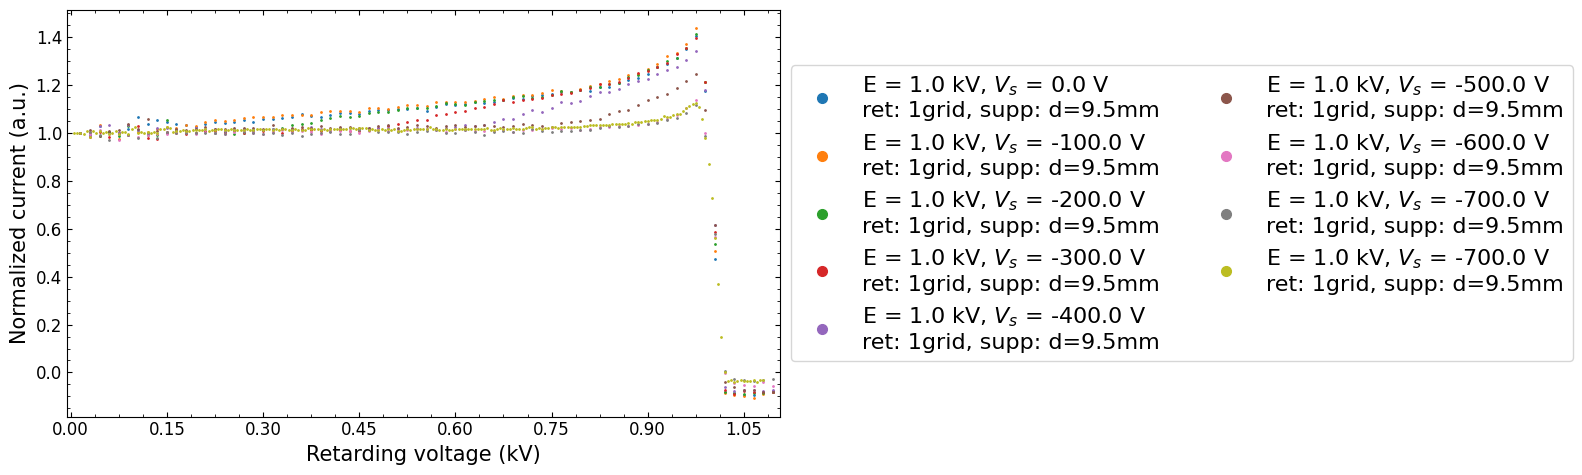

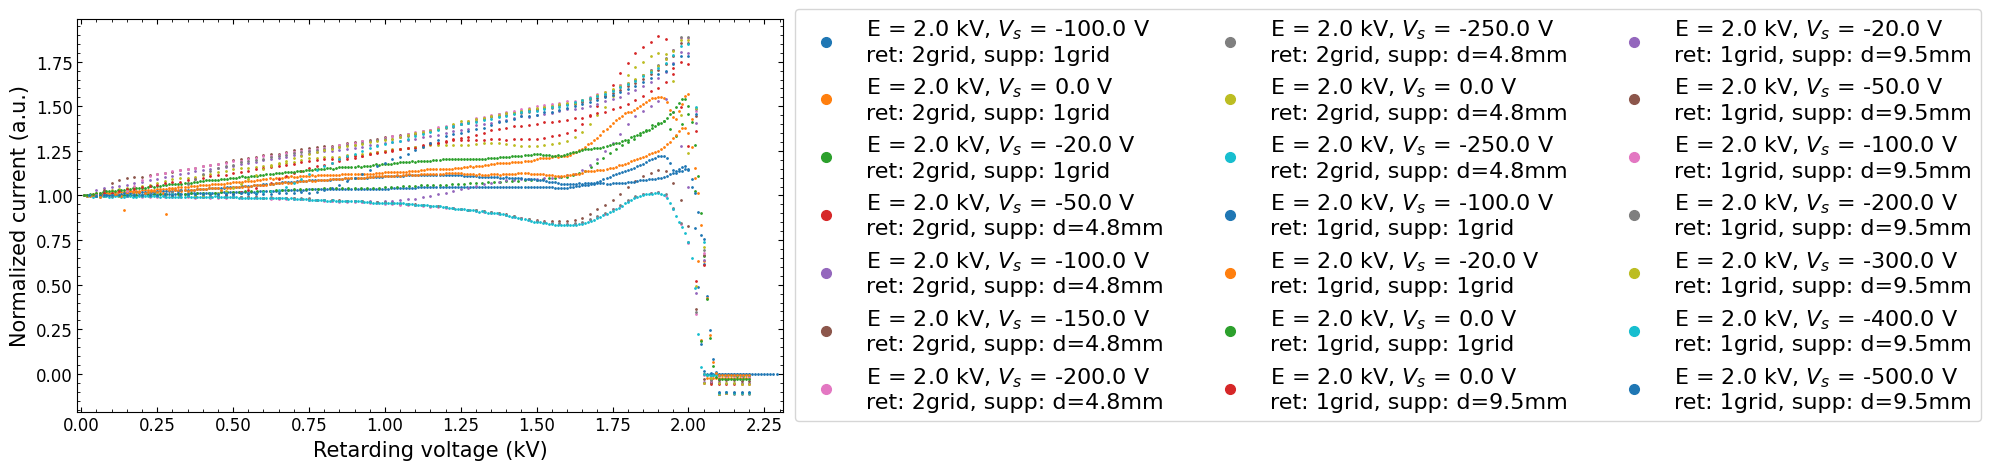

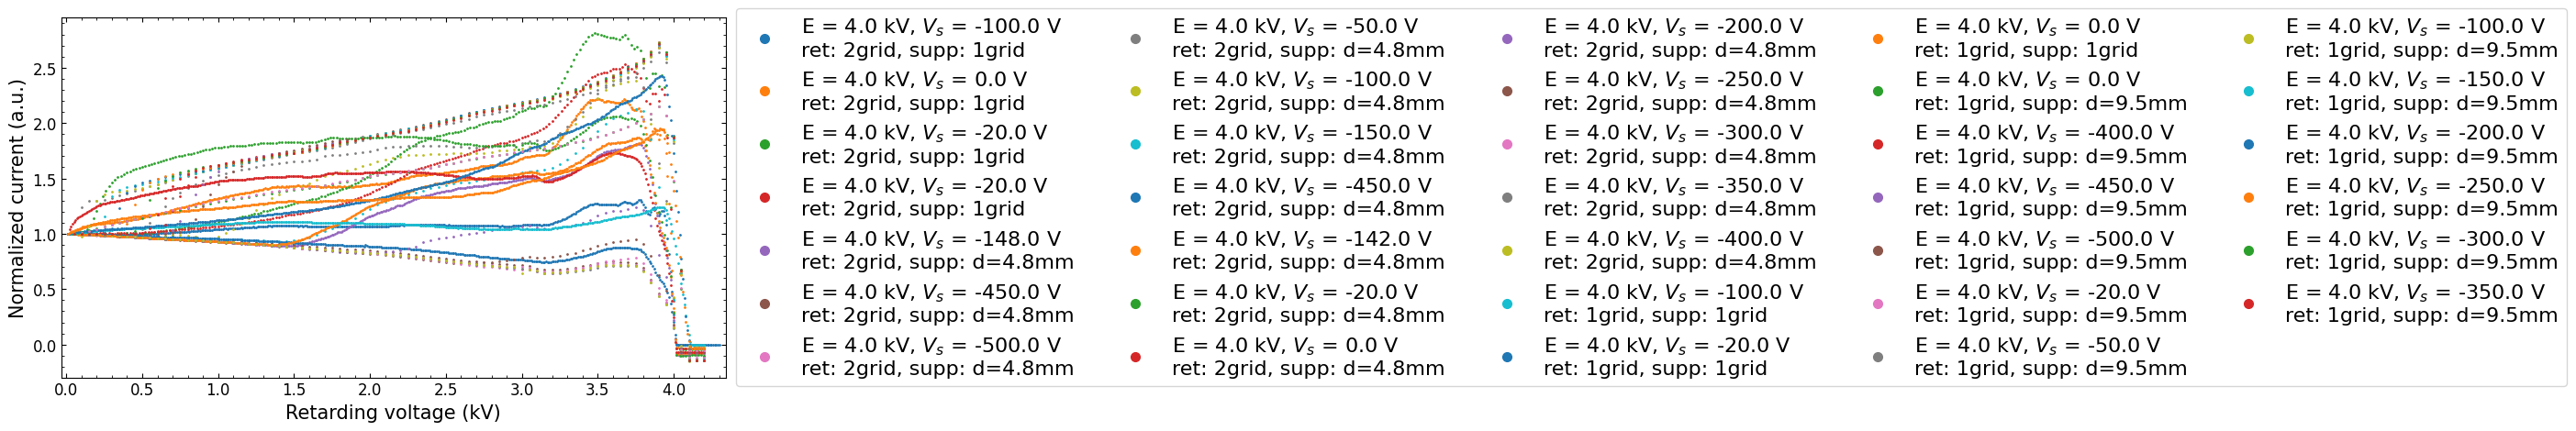

In [5]:
# load all RFA data files

all_rfa_datas = []
# Loop through the raw data folder and its subfolders
for root, dirs, files in os.walk(r"raw data"):
    for file in files:
        if file.endswith(".txt") and not ("wein" in str(file) or "wien" in str(file)):
            file_path = os.path.join(root, file)
            rfa = RFAData(file_path)
            rfa.is_normalized = True # normalize all by the starting current
            all_rfa_datas.append(rfa)

# check loaded data
for e in [1, 2, 4]:
    format_plot(nrows=7, rfa_datas=filtered(all_rfa_datas, energy=[e], is_peak=[False], day=list(range(5))))

# filtered(all_rfa_datas, energy=[4],
#          is_peak=[True], 
#          day=[1], 
#          supp_voltage=[-100]
#          )[0].calc_fwhm(plot=True)

# for m_c in [None, 1.15e-10]:
#     filtered(all_rfa_datas, energy=[4],
#             is_peak=[True], 
#             day=[2], 
#             supp_voltage=[-450]
#             )[0].calc_fwhm(plot=True, max_current=m_c)

# filtered(all_rfa_datas, energy=[4],
#          is_peak=[True], 
#          day=[3], 
#          supp_voltage=[]
#          )[0].calc_fwhm(plot=True)

# filtered(all_rfa_datas, energy=[4],
#          is_peak=[True], 
#          day=[4], 
#          supp_voltage=[-500]
#          )[0].calc_fwhm(plot=True)

2kV_max-supp_1each-day.png


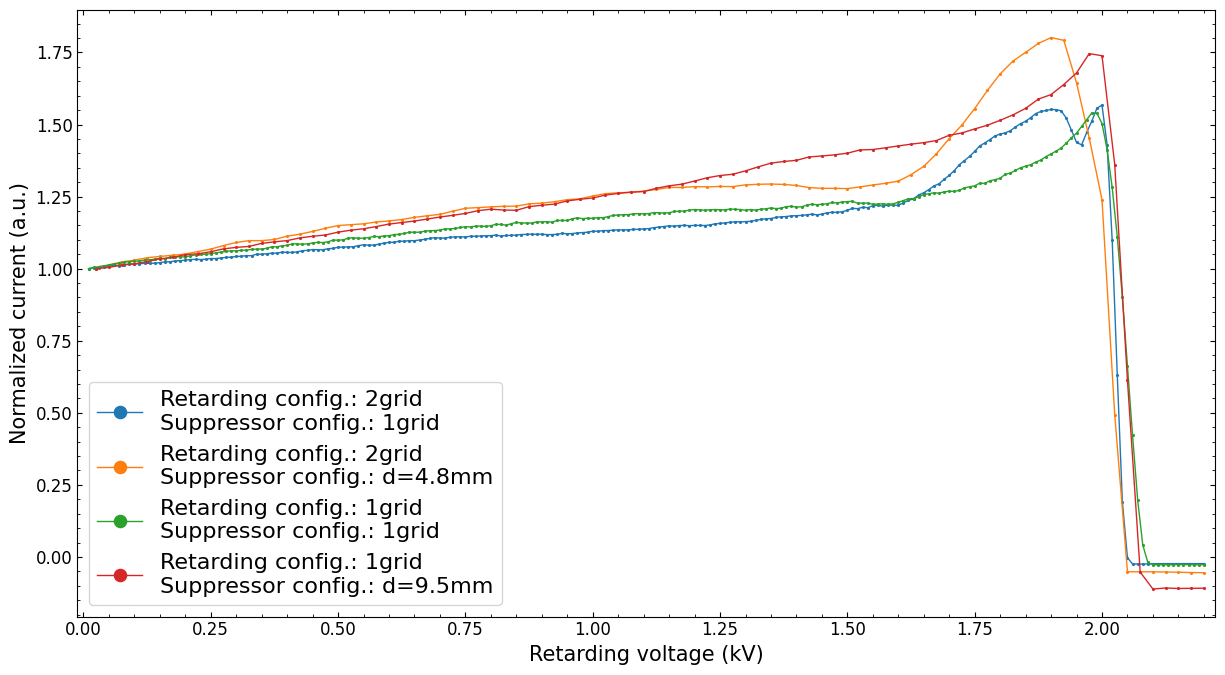

4kV_max-supp_1each-day.png


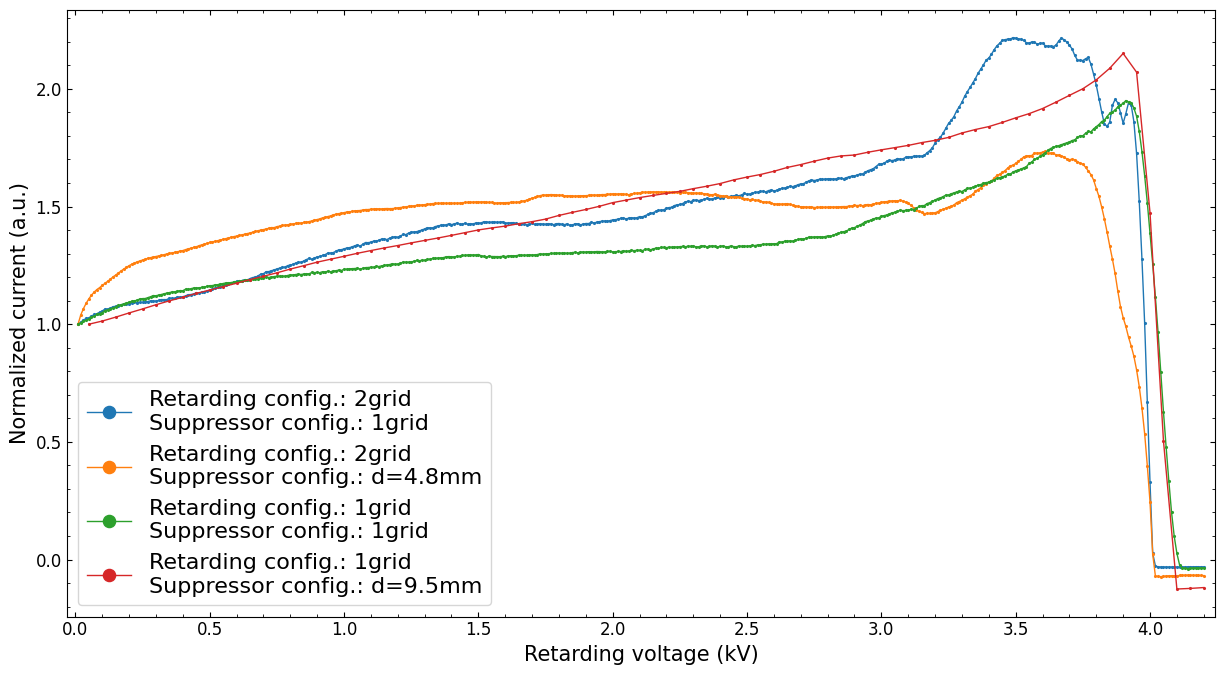

In [34]:
for e in [2, 4]:
    fig, ax = format_plot(show=False)
    for day in range(1, 5):
        highest_s = get_w_highest_supp(filtered(all_rfa_datas,
                                                day=[day], energy=[e], is_peak=[False]))
        ax.plot(highest_s.retarding_voltage, highest_s.current, 
                label=f"Retarding config.: {highest_s.ret_config}\nSuppressor config.: {highest_s.supp_config}",
                marker="o", markersize=1.25,
                linestyle="-", linewidth=1)
    format_plot(figax=(fig, ax), is_norm=True, show=False, figsize=(12.5, 7))
    print(name := f"{e}kV_max-supp_1each-day.png")
    plt.savefig(f"./plot exports/{name}")
    plt.show()

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_with_range_break(x, y, break_range, figsize=(8, 6), title=None, figaxs=None):
    """
    Create a plot with a broken y-axis removing a specified range,
    with subplot heights proportional to their data ranges and non-overlapping labels.
    
    Parameters:
    -----------
    x : array-like
        The x-coordinates of the data
    y : array-like
        The y-coordinates of the data
    break_range : tuple
        The (min, max) y-values of the range to remove
    figsize : tuple, optional
        Figure size in inches (width, height)
    title : str, optional
        Title for the plot
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    (ax1, ax2) : tuple
        The top and bottom axis objects
    """
    
    break_min, break_max = break_range
    
    # Calculate the ranges for top and bottom plots
    bottom_data = y[y < break_min]
    top_data = y[y > break_max]
    
    if len(bottom_data) > 0:
        bottom_min = np.min(bottom_data)
    else:
        bottom_min = 0
        
    if len(top_data) > 0:
        top_max = np.max(top_data)
    else:
        top_max = break_max * 1.2
    
    # Add padding to prevent label overlap
    padding_factor = 0.1  # Adjust this to control label separation
    bottom_range = break_min - bottom_min
    top_range = top_max - break_max
    
    bottom_max = break_min - (bottom_range * padding_factor)
    top_min = break_max + (top_range * padding_factor)
    
    # Calculate plot heights based on padded data ranges
    top_range_padded = top_max - top_min
    bottom_range_padded = bottom_max - bottom_min
    total_range = top_range_padded + bottom_range_padded
    
    # Set relative heights of subplots
    top_height = top_range_padded / total_range
    bottom_height = bottom_range_padded / total_range
    
    # Create figure with custom gridspec for different subplot heights
    if figaxs:
        fig, (ax1, ax2) = figaxs
    else:
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(2, 1, height_ratios=[top_height, bottom_height], hspace=0.05)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
    
    # Plot the same data on both axes
    ax1.plot(x, y)
    ax2.plot(x, y)
    
    # Set the y-axis limits with padding
    ax2.set_ylim(bottom_min, bottom_max)
    ax1.set_ylim(top_min, top_max)
    
    # Hide the spines between ax1 and ax2
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)
    ax2.xaxis.tick_bottom()
    
    # Add the diagonal lines to indicate the break
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                 linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    
    # Add title if provided
    if title:
        fig.suptitle(title)
    
    return fig, (ax1, ax2)


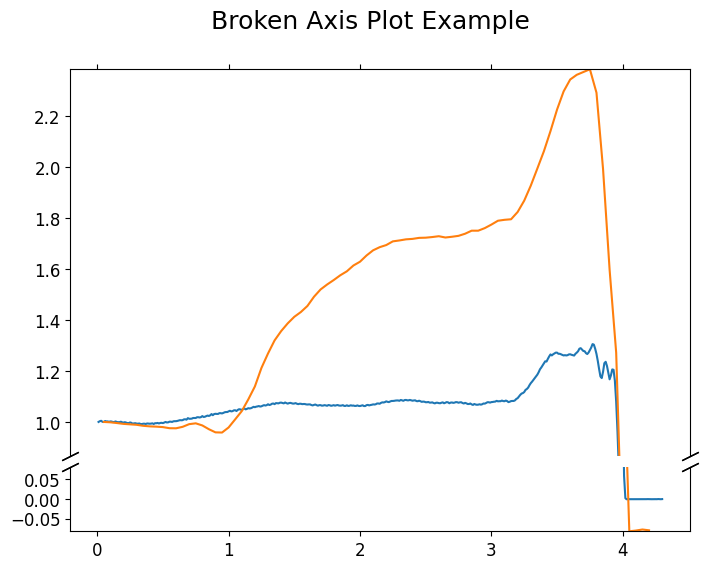

In [ ]:
data = all_rfa_datas[0]
# Create the broken axis plot
fig, (ax1, ax2) = plot_with_range_break(
    x=data.retarding_voltage,
    y=data.current,
    break_range=(0.1, 0.7),
    title="Broken Axis Plot Example"
)
data = all_rfa_datas[20]
# Create the broken axis plot
fig, (ax1, ax2) = plot_with_range_break(
    x=data.retarding_voltage,
    y=data.current,
    break_range=(0.1, 0.7),
    title="Broken Axis Plot Example",
    figaxs=(fig, (ax1, ax2))
)

# TODO

- ask luk for current errors?
### Plots: 
- Overall behaviors: 4 days, 2k and 4k each, at 1 Vsupp for each
- Vsupp sweeps: day2 4k, day4 4k, day4 1k
- Res: overall 4 days 4k + table for all (graphs in the appendix)
